# Benchmark GLM Newton Solvers: Cholesky and LSMR
This notebook is based on scikit-learn [PR #23507](https://github.com/scikit-learn/scikit-learn/pull/23507).

#### Table of Contents
1. [Benchmarking on Synthetic Data](#chapter_1)
2. [Complex Real Datasets](#chapter_2)
3. [Solver Performance Profiles](#chapter_3)
4. XXX Some Experiments

#### Abstract
This notebook carries out an analysis of new Newton solvers for GLMs in scikit-learn.
- newton-cholesky: Newton solver based on a Cholesky decomposition (LDL) of the hessian matrix.
- newton-qr-cholesky: Same as above but on the triangular matrix R of the QR decomposition X'=QR
- newton-lsmr: This one uses the LSMR solver for the iterative reweighted least squares (IRLS) fomulation

Results show large differences between synthetic and real data. 

## 1. Benchmarking on Synthetic Data <a name="chapter_1"></a>

In this benchmark we use synthetic data created with either [make_regression](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) or [make_correlated_data](https://benchopt.github.io/generated/benchopt.datasets.simulated.make_correlated_data.html#benchopt.datasets.simulated.make_correlated_data).

Note: We try to make a fair comparison by searching for a model specific `tol` that guarantees at the found minimum during optimization is at least as small as a reference model.
The reference model is choosen to be either `"newton-cholesky"` (`n_samples > n_features`) or `"newton-qr-cholesky"`.

In [12]:
from collections.abc import Iterable
import warnings

from benchopt.datasets import make_correlated_data
import matplotlib.pyplot as plt
from neurtu import delayed, timeit, Benchmark
import numpy as np
import pandas as pd

import sklearn
from sklearn.exceptions import ConvergenceWarning
from sklearn.datasets import make_regression
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from sklearn._loss import HalfPoissonLoss
from sklearn.linear_model._linear_loss import LinearModelLoss

In [2]:
def get_training_loss(model, X, y):
    return LinearModelLoss(
        base_loss=model._base_loss,
        fit_intercept=model.fit_intercept
    ).loss(
        coef=np.r_[np.squeeze(model.coef_), model.intercept_] if model.fit_intercept else np.squeeze(model.coef_),
        X=X,
        y=y,
        l2_reg_strength=model.alpha,
        sample_weight=np.full_like(y, fill_value=(1. / y.shape[0])),
    )

def make_solver_benchmark(
    n_features=50,
    n_samples=np.linspace(1000, 100_000, 5, dtype=int),
    ax=None,
    repeat=1,
    correlated=False,
    metric_name="wall_time",
    solver_list = ["lbfgs", "newton-cholesky", "newton-qr-cholesky", "newton-lsmr"],
    **kwargs,
):
    """Benchmark different solvers of PoissonRegressor"""
    loop_features = False
    xlabel = "n_samples"
    if isinstance(n_features, Iterable):
        loop_features = True
        xlabel = "n_features"
        n_features = np.asarray(n_features)
        if isinstance(n_samples, Iterable):
            raise ValueError(
                "Wither n_features or n_samples is allowed to be array-like, not both."
            )
    if isinstance(n_samples, Iterable):
        n_samples = np.asarray(n_samples)

    dataset_kwargs = dict(
        n_samples=np.max(n_samples),
        n_features=np.max(n_features),
        random_state=42,
    )
    if correlated > 0:
        X, y, _ = make_correlated_data(
            rho=correlated,
            density=0.9,
            **dataset_kwargs
        )
    else:
        X, y = make_regression(
            effective_rank=int(np.max(n_features) * 0.9),
            tail_strength=0.6,
            n_informative=int(np.max(n_features) * 0.9),
            **dataset_kwargs
        )
    # make sure the target is positive
    y += np.abs(y.min()) + 0.1
    
    X = StandardScaler().fit_transform(X)

    if (loop_features and np.max(n_features) > 10_000) or (not loop_features and np.max(n_samples) > 10_000):
        scale_factor = 1000
    
    else:
        scale_factor = 1

    bench = [] 
    
    ref = PoissonRegressor(**kwargs)
    ref.set_params(tol=1e-12)
    tol = kwargs.get("tol", 1e-4)

    loop_range = n_features if loop_features else n_samples
    for n in loop_range:
        if loop_features:
            n_s = n_samples 
            n_f = n
        else:
            n_s = n
            n_f = n_features
        if n_f >= n_s:
            ref.set_params(solver="newton-cholesky")
        else:
            ref.set_params(solver="newton-qr-cholesky", **kwargs)
        ref.fit(X, y)
        ref_loss = get_training_loss(ref, X, y)
        for solver in solver_list:
            # search for equivalent tolerance such that loss is at least as small as ref_loss:
            model = PoissonRegressor(solver=solver, **kwargs)
            model.set_params(warm_start=True)
            for model_tol in np.logspace(np.log10(tol), np.log10(1e-12), 10):
                model.set_params(tol=model_tol)
                model.fit(X, y)
                #if np.max(np.abs(model.coef_ / ref.coef_ - 1)) <= tol:
                #    break
                model_loss = get_training_loss(model, X, y)
                if model_loss <= ref_loss:
                    break
            model = PoissonRegressor(solver=solver, **kwargs)
            model.set_params(tol=model_tol)
            bench.append(
                delayed(
                    model,
                    tags={
                        "n_samples": n_s,
                        "n_features": n_f,
                        "solver": solver,
                        "tol": model_tol,
                    },
                ).fit(X[:n_s, :n_f], y[:n_s])
            )
    res = Benchmark(repeat=repeat, **{metric_name: True})(bench)
    res = res.reset_index(level=-1)  # bring multiindex tol as a column
    if repeat > 1:
        res_plot = res.loc[:, (metric_name, "mean")].unstack(-1)
    else:
        res_plot = res.loc[:, metric_name].unstack(-1)
    
    if loop_features:
        res_plot.index = res_plot.index.droplevel("n_samples")
    else:
        res_plot.index = res_plot.index.droplevel("n_features")
    #return res_plot
    
    ax = res_plot.plot(marker="o", ax=ax)
    if loop_features:
        ax.set(
            title=f"n_samples={n_samples}",
            #xlim=(0, np.max(n_features)),
        )
    else:
        ax.set(
            title=f"n_features={n_features}",
            #xlim=(0, np.max(n_samples)),
        )
    if metric_name == "wall_time":
        ax.set(ylabel="wall time (s)")
    elif metric_name == "peak_memory":
        ax.set(ylabel="peak memory (MB)")
    ax.set(xlabel=xlabel)
    ax.ticklabel_format(style="sci", scilimits=(-3,3))

    return res, ax

In [3]:
# make_solver_benchmark(n_features=10, n_samples=np.linspace(100, 20_000, 5, dtype=int))

In [4]:
# make_solver_benchmark(n_features=[10, 20, 30], n_samples=10)

#### 1.1. Dense n_samples>>n_features, alpha=1e-2, tol=1e-4, PoissonRegressor

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 46min 45s, sys: 4min 58s, total: 51min 43s
Wall time: 11min 51s


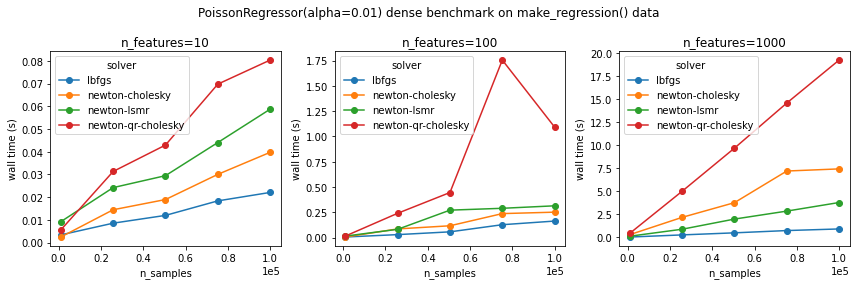

In [5]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

kwargs = {"alpha": 1e-2, "tol": 1e-4}

make_solver_benchmark(n_features=10, ax=ax[0])
make_solver_benchmark(n_features=100, ax=ax[1])
make_solver_benchmark(n_features=1000, ax=ax[2])

with sklearn.config_context(print_changed_only=True):
    fig.suptitle(
        str(PoissonRegressor(**kwargs))
        + " dense benchmark on make_regression() data"
    )
fig.tight_layout()

#### 1.2. Dense n_samples>>n_features, alpha=1e-2, tol=1e-5, PoissonRegressor on Correlated Data

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 54min 24s, sys: 5min 27s, total: 59min 51s
Wall time: 13min 51s


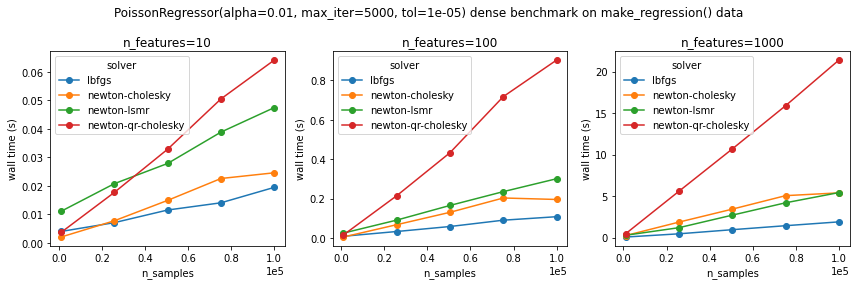

In [6]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

kwargs = {"alpha": 1e-2, "tol": 1e-5, "max_iter": 5_000}

with warnings.catch_warnings():
    # ConvergenceWarning: lbfgs failed to converge (status=1):
    # STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    result_10, _ = make_solver_benchmark(correlated=0.5, n_features=10, ax=ax[0])
    result_100, _ = make_solver_benchmark(correlated=0.5, n_features=100, ax=ax[1])
    result_1000, _ = make_solver_benchmark(correlated=0.5, n_features=1000, ax=ax[2])

with sklearn.config_context(print_changed_only=True):
    fig.suptitle(
        str(PoissonRegressor(**kwargs))
        + " dense benchmark on make_regression() data"
    )
fig.tight_layout()

In [7]:
result_100

tol  wall_time
n_samples n_features solver                                     
1000      100        lbfgs               2.782559e-08   0.008378
                     newton-cholesky     1.000000e-04   0.004455
                     newton-qr-cholesky  1.000000e-04   0.014572
                     newton-lsmr         2.154435e-07   0.024395
25750     100        lbfgs               2.782559e-08   0.032544
                     newton-cholesky     1.000000e-04   0.067094
                     newton-qr-cholesky  1.000000e-04   0.214069
                     newton-lsmr         2.154435e-07   0.090359
50500     100        lbfgs               2.782559e-08   0.057964
                     newton-cholesky     1.000000e-04   0.130048
                     newton-qr-cholesky  1.000000e-04   0.432736
                     newton-lsmr         2.154435e-07   0.164974
75250     100        lbfgs               2.782559e-08   0.090071
                     newton-cholesky     1.000000e-04   0.202841
                     newton-qr-cholesky  1.000000e-04   0.717722
                     newton-lsmr         2.154435e-07   0.235135
100000    100        lbfgs               2.782559e-08   0.107792
                     newton-cholesky     1.000000e-04   0.195313
                     newton-qr-cholesky  1.000000e-04   0.903547
                     newton-lsmr         2.154435e-07   0.300661

#### 1.3. Dense n_features>>n_samples, alpha=1e-2, tol=1e-5

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 45min 5s, sys: 5min 43s, total: 50min 49s
Wall time: 16min 27s


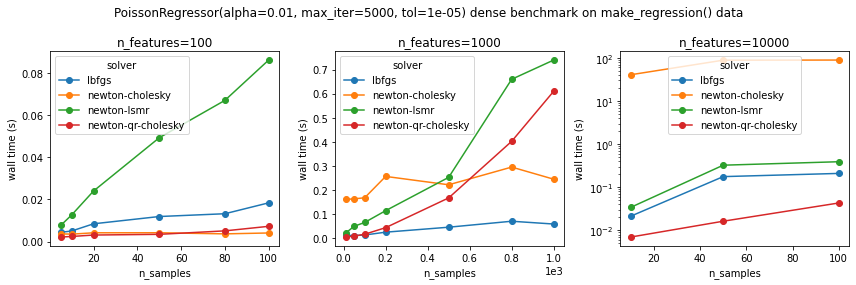

In [8]:
%%time

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

kwargs = {"alpha": 1e-2, "tol": 1e-5, "max_iter": 5_000}

with warnings.catch_warnings():
    # ConvergenceWarning: lbfgs failed to converge (status=2):
    # STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    make_solver_benchmark(correlated=0.5, n_features=100, n_samples=[5, 10, 20, 50, 80, 100], ax=ax[0])
    make_solver_benchmark(correlated=0.5, n_features=1000, n_samples=[10, 50, 100, 200, 500, 800, 1000], ax=ax[1])
    make_solver_benchmark(correlated=0.5, n_features=10_000, n_samples=[10, 50, 100], ax=ax[2])

with sklearn.config_context(print_changed_only=True):
    fig.suptitle(
        str(PoissonRegressor(**kwargs))
        + " dense benchmark on make_regression() data"
    )
ax[2].set_yscale('log')
fig.tight_layout()

#### 1.4. Dependency on n_features: Dense n_features>>n_samples, alpha=1e-2, tol=1e-5

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 24min 24s, sys: 2min 51s, total: 27min 15s
Wall time: 7min 59s


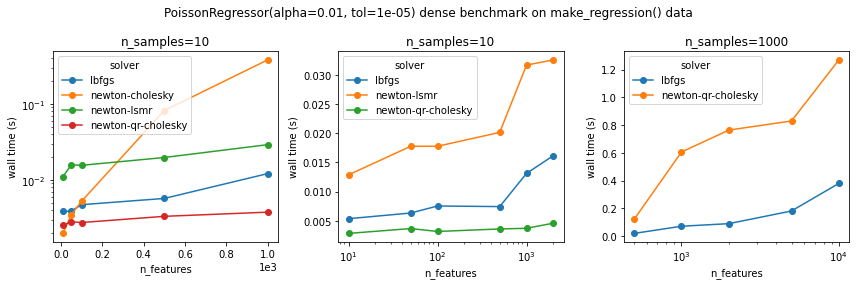

In [13]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

kwargs = {"alpha": 1e-2, "tol": 1e-5}

with warnings.catch_warnings():
    # ConvergenceWarning: lbfgs failed to converge (status=1):
    # STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    make_solver_benchmark(n_samples=10, n_features=[10, 50, 100, 500, 1000], ax=ax[0])
    make_solver_benchmark(
        n_samples=10,
        n_features=[10, 50, 100, 500, 1000, 2000],
        solver_list=["lbfgs", "newton-qr-cholesky", "newton-lsmr"], # without "newton-cholesky"
        ax=ax[1],
    )
    make_solver_benchmark(
        n_samples=1000,
        n_features=[500, 1000, 2000, 5000, 10_000],
        solver_list=["lbfgs", "newton-qr-cholesky"],
        ax=ax[2],
    )

with sklearn.config_context(print_changed_only=True):
    fig.suptitle(
        str(PoissonRegressor(**kwargs))
        + " dense benchmark on make_regression() data"
    )

ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
fig.tight_layout()

## 2. Complex Real Datasets <a name="chapter_2"></a>
### 2.1 PoissonRegression on freMTPL2freq

In [1]:
import numpy as np
from scipy import sparse
from sklearn._loss import HalfPoissonLoss
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer


df = fetch_openml(data_id=41214, as_frame=True, parser="auto").frame
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False), StandardScaler()
)
linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("binned_numeric", KBinsDiscretizer(n_bins=10, subsample=None), ["VehAge", "DrivAge"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
)
y = df["Frequency"]
w = df["Exposure"]
X = linear_model_preprocessor.fit_transform(df)

In [2]:
X.shape

(678013, 75)

#### Sparse X

In [3]:
sparse.issparse(X)

True

In [4]:
%time PoissonRegressor(solver="lbfgs", alpha=1e-4, tol=1e-4, max_iter=1000).fit(X, y, sample_weight=w); None

CPU times: user 25 s, sys: 2.39 s, total: 27.4 s
Wall time: 4.23 s


In [5]:
%time PoissonRegressor(solver="newton-cholesky", alpha=1e-4, tol=1e-4).fit(X, y, sample_weight=w); None

CPU times: user 7.33 s, sys: 675 ms, total: 8 s
Wall time: 1.86 s


In [6]:
%time PoissonRegressor(solver="newton-lsmr", alpha=1e-4, tol=1e-4).fit(X, y, sample_weight=w); None

CPU times: user 5 s, sys: 1.21 s, total: 6.21 s
Wall time: 980 ms


#### Dense X

In [7]:
X_dense = X.toarray()

In [8]:
%time PoissonRegressor(solver="lbfgs", alpha=1e-4, tol=1e-4, max_iter=1000).fit(X_dense, y, sample_weight=w); None

CPU times: user 2min 1s, sys: 12.2 s, total: 2min 13s
Wall time: 19.1 s


In [9]:
%time PoissonRegressor(solver="newton-cholesky", alpha=1e-4, tol=1e-4).fit(X_dense, y, sample_weight=w); None

CPU times: user 11.9 s, sys: 1.91 s, total: 13.8 s
Wall time: 2.5 s


In [10]:
%time PoissonRegressor(solver="newton-lsmr", alpha=1e-4, tol=1e-4).fit(X_dense, y, sample_weight=w); None

CPU times: user 19.3 s, sys: 1.25 s, total: 20.5 s
Wall time: 4 s


#### SplineTransformer instead of KBinsDiscretizer

In [13]:
from sklearn.preprocessing import OrdinalEncoder, SplineTransformer

preprocessor_with_spline = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("binned_numeric", SplineTransformer(n_knots=8, degree=3), ["VehAge", "DrivAge"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OrdinalEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
)
X_spline = preprocessor_with_spline.fit_transform(df)

In [15]:
X_spline.shape, sparse.issparse(X_spline)

((678013, 27), False)

In [9]:
%time PoissonRegressor(solver="lbfgs", alpha=1e-4, tol=1e-4, max_iter=1000).fit(X_spline, y, sample_weight=w); None

CPU times: user 1min 51s, sys: 12 s, total: 2min 3s
Wall time: 16.3 s


In [10]:
%time PoissonRegressor(solver="newton-cholesky", alpha=1e-4, tol=1e-4).fit(X_spline, y, sample_weight=w); None

CPU times: user 6.83 s, sys: 1.59 s, total: 8.42 s
Wall time: 1.12 s


In [11]:
%time PoissonRegressor(solver="newton-lsmr", alpha=1e-4, tol=1e-4).fit(X_spline, y, sample_weight=w); None

CPU times: user 11.6 s, sys: 922 ms, total: 12.6 s
Wall time: 2.52 s


#### Comparison of Losses and Gradients Achieved

In [4]:
# loss
params = dict(alpha=1e-4, tol=1e-4, max_iter=1000)
reg_lbfgs = PoissonRegressor(solver="lbfgs", **params).fit(X, y, sample_weight=w)
reg_cholesky = PoissonRegressor(solver="newton-cholesky", **params).fit(X, y, sample_weight=w)
reg_lsmr = PoissonRegressor(solver="newton-lsmr", **params).fit(X, y, sample_weight=w)

lml = LinearModelLoss(base_loss=HalfPoissonLoss(), fit_intercept=True)

for reg, solver in [(reg_lbfgs, "lbfgs"), (reg_cholesky, "cholesky"), (reg_lsmr, "lsmr")]:
    this_loss = lml.loss(
        coef=np.r_[reg.coef_, reg.intercept_],
        X=X,
        y=np.asarray(y),
        sample_weight=np.asarray(w) / np.sum(w),
        l2_reg_strength=1e-4,
    )
    this_grad = lml.gradient(
        coef=np.r_[reg.coef_, reg.intercept_],
        X=X,
        y=np.asarray(y),
        sample_weight=np.asarray(w) / np.sum(w),
        l2_reg_strength=1e-4,
    )
    print(f"solver={solver:<8} has loss = {this_loss:0.10f} "
          f"gradient 2-norm = {np.linalg.norm(this_grad):0.10f} "
          f"gradient inf-norm = {np.linalg.norm(this_grad, ord=np.inf)}"
         )

solver=lbfgs    has loss = 0.3159405244 gradient 2-norm = 0.0002915615 gradient inf-norm = 9.902745649472464e-05
solver=cholesky has loss = 0.3159052779 gradient 2-norm = 0.0000049585 gradient inf-norm = 4.95662287833316e-06
solver=lsmr     has loss = 0.3159284188 gradient 2-norm = 0.0000654960 gradient inf-norm = 3.57521931752307e-05


#### Further infos and investigations

In [5]:
PoissonRegressor(solver="newton-cholesky", alpha=1e-4, tol=1e-4, verbose=2).fit(X, y, sample_weight=w); None

Newton iter=1
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.000777889210935967 <= -2.086722104674559e-05 True
  Check Convergence
    1. max |gradient| 3.2223832622617516 <= 0.0001
Newton iter=2
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.013406845352291585 <= -1.1052070547131876e-05 True
  Check Convergence
    1. max |gradient| 0.7443169432323894 <= 0.0001
Newton iter=3
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.001731892020135184 <= -1.5306825069150627e-06 True
  Check Convergence
    1. max |gradient| 0.10924809781031802 <= 0.0001
Newton iter=4
  Backtracking Line Search
    eps=10 * finfo.eps=3.552713678800501e-15
    line search iterati

In [6]:
PoissonRegressor(solver="newton-lsmr", alpha=1e-4, tol=1e-4, verbose=3).fit(X, y, sample_weight=w); None

Newton iter=1
 
LSMR            Least-squares solution of  Ax = b

The matrix A has 678088 rows and 76 columns
damp = 0.00000000000000e+00

atol = 1.00e-04                 conlim = 1.00e+08

btol = 1.00e-04             maxiter =   678013

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  2.349e+00  5.580e-01   1.0e+00  1.0e-01
     1  1.56221e-03  2.349e+00  2.696e-02   1.0e+00  6.1e-04  1.9e+01  1.0e+00
     2  5.04129e-03  2.347e+00  1.659e-02   1.0e+00  3.7e-04  1.9e+01  7.1e+01
     3  1.96377e-02  2.343e+00  9.168e-03   1.0e+00  2.1e-04  1.9e+01  1.5e+02
     4  2.07147e-02  2.343e+00  8.711e-03   1.0e+00  2.0e-04  1.9e+01  1.9e+02
     5  2.54980e-02  2.341e+00  6.269e-03   1.0e+00  1.0e-04  2.6e+01  1.3e+02
     6  2.90304e-02  2.340e+00  3.749e-03   1.0e+00  6.0e-05  2.7e+01  1.5e+02
 
LSMR finished
The least-squares solution is good enough, given atol     
istop =       2    normr = 2.3e+00
    normA = 2.7e+01    normAr = 3.7

In [29]:
%load_ext line_profiler

In [30]:
%lprun -f sklearn.linear_model._glm.glm.LSMRNewtonSolver.inner_solve PoissonRegressor(solver="newton-lsmr").fit(X, y)

Timer unit: 1e-06 s

Total time: 0.421823 s
File: /Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/glm.py
Function: inner_solve at line 683

Line #      Hits         Time  Per Hit   % Time  Line Contents
   683                                               def inner_solve(self):
   684                                                   """Compute Newton step.
   685                                           
   686                                                   Sets self.coef_newton via LSMR.
   687                                                   Also sets self.A_norm for better control over tolerance in LSMR.
   688                                                   """
   689         4         40.0     10.0      0.0          n_samples, n_features = self.X.shape
   690         4       3800.0    950.0      0.9          sqrt_h = np.sqrt(self.h)
   691                                           
   692         4       9977.0   2494.2      2.4          b = np.r_[-self.g / 

### 2.2 Binary Classification on Kick Dataset

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn._loss import HalfBinomialLoss
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.linear_model._glm.glm import _GeneralizedLinearRegressor
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


class BinomialRegressor(_GeneralizedLinearRegressor):
    def _get_loss(self):
        return HalfBinomialLoss()


df = fetch_openml(data_id=41162, as_frame=True, parser="auto").frame

linear_model_preprocessor = ColumnTransformer(
    [
        (
            "passthrough_numeric",
            make_pipeline(SimpleImputer(), StandardScaler()),
            [
                "MMRAcquisitionAuctionAveragePrice",
                "MMRAcquisitionAuctionCleanPrice",
                "MMRCurrentAuctionAveragePrice",
                "MMRCurrentAuctionCleanPrice",
                "MMRCurrentRetailAveragePrice",
                "MMRCurrentRetailCleanPrice",
                "MMRCurrentRetailAveragePrice",
                "MMRCurrentRetailCleanPrice",
                "VehBCost",
                "VehOdo",
                "VehYear",
                "VehicleAge",
                "WarrantyCost",
            ],
        ),
        (
            "onehot_categorical",
            OneHotEncoder(min_frequency=10),
            [
                "Auction",
                "Color",
                "IsOnlineSale",
                "Make",
                "Model",
                "Nationality",
                "Size",
                "SubModel",
                "Transmission",
                "Trim",
                "WheelType",
            ],
        ),
    ],
    remainder="drop",
)
y = np.asarray(df["IsBadBuy"] == "1", dtype=float)
X = linear_model_preprocessor.fit_transform(df)

In [2]:
X.shape

(72983, 1076)

In [3]:
sparse.issparse(X)

True

In [4]:
df.dtypes

IsBadBuy                             category
PurchDate                               int64
Auction                              category
VehYear                                 int64
VehicleAge                              int64
Make                                 category
Model                                category
Trim                                 category
SubModel                             category
Color                                category
Transmission                         category
WheelTypeID                          category
WheelType                            category
VehOdo                                  int64
Nationality                          category
Size                                 category
TopThreeAmericanName                 category
MMRAcquisitionAuctionAveragePrice     float64
MMRAcquisitionAuctionCleanPrice       float64
MMRAcquisitionRetailAveragePrice      float64
MMRAcquisitonRetailCleanPrice         float64
MMRCurrentAuctionAveragePrice     

In [5]:
alpha = 1e-4

In [6]:
# C = 1/alpha/n_samples
clf_lbfgs = LogisticRegression(solver="lbfgs", C=1/5 * 1 / 1e-2, tol=1e-6, max_iter=1000).fit(np.arange(5)[:, None], [0, 0, 1, 1, 1])
clf_lbfgs2 = BinomialRegressor(solver="lbfgs", alpha=1e-2, tol=1e-6, max_iter=1000).fit(np.arange(5)[:, None], [0, 0, 1, 1, 1])
clf_lbfgs.intercept_[0], clf_lbfgs2.intercept_, clf_lbfgs.coef_[0], clf_lbfgs2.coef_

(-5.1324121928074256,
 -5.132371277107675,
 array([3.42204214]),
 array([3.42205471]))

In [13]:
%time clf_lbfgs = LogisticRegression(solver="lbfgs", C=1 / alpha / X.shape[0], tol=1e-4, max_iter=1000).fit(X, y)

CPU times: user 1.53 s, sys: 5 ms, total: 1.54 s
Wall time: 1.54 s


In [14]:
%time clf_newton_cg = LogisticRegression(solver="newton-cg", C=1 / alpha / X.shape[0], tol=1e-4, max_iter=1000).fit(X, y)

CPU times: user 1.52 s, sys: 29.8 ms, total: 1.55 s
Wall time: 1.55 s


In [15]:
%time clf_lbfgs2 = BinomialRegressor(solver="lbfgs", alpha=alpha, tol=1e-4, max_iter=1000).fit(X, y)

CPU times: user 3.24 s, sys: 70.4 ms, total: 3.31 s
Wall time: 447 ms


In [16]:
%time clf_newton_cholesky = BinomialRegressor(solver="newton-cholesky", alpha=alpha, tol=1e-4).fit(X, y)

CPU times: user 5.32 s, sys: 737 ms, total: 6.06 s
Wall time: 842 ms


In [17]:
%time clf_newton_lsmr = BinomialRegressor(solver="newton-lsmr", alpha=alpha, tol=1e-4).fit(X, y)

CPU times: user 3.15 s, sys: 900 ms, total: 4.05 s
Wall time: 544 ms


In [18]:
# Note the relatively large deviations of the fitted intercept term!!! 
clf_lbfgs.intercept_[0], clf_lbfgs2.intercept_, clf_newton_cg.intercept_[0], clf_newton_cholesky.intercept_, clf_newton_lsmr.intercept_

(-1.9484926740059627,
 -1.9357562924632725,
 -1.9697611812176623,
 -1.9697465142025918,
 -1.9002494018471947)

In [20]:
(
    np.sum(np.abs(clf_lbfgs.coef_[0] - clf_lbfgs2.coef_)),
    np.sum(np.abs(clf_lbfgs.coef_[0] - clf_newton_cg.coef_[0])),
    np.sum(np.abs(clf_lbfgs.coef_[0] - clf_newton_cholesky.coef_)),
)

(12.311858390285998, 0.3486240037254509, 0.3515702677746094)

In [21]:
lml = LinearModelLoss(base_loss=HalfBinomialLoss(), fit_intercept=True)
sw = np.full_like(y, fill_value=1 / y.shape[0])

In [22]:
loss_lbfgs = lml.loss(coef=np.r_[clf_lbfgs.coef_[0], clf_lbfgs.intercept_], X=X, y=y, sample_weight=sw, l2_reg_strength=alpha)
loss_newton_cg = lml.loss(coef=np.r_[clf_newton_cg.coef_[0], clf_newton_cg.intercept_], X=X, y=y, sample_weight=sw, l2_reg_strength=alpha)
loss_lbfgs2 = lml.loss(coef=np.r_[clf_lbfgs2.coef_, clf_lbfgs2.intercept_], X=X, y=y, sample_weight=sw, l2_reg_strength=alpha)
loss_newton_cholesky = lml.loss(coef=np.r_[clf_newton_cholesky.coef_, clf_newton_cholesky.intercept_], X=X, y=y, sample_weight=sw, l2_reg_strength=alpha)
loss_newton_lsmr = lml.loss(coef=np.r_[clf_newton_lsmr.coef_, clf_newton_lsmr.intercept_], X=X, y=y, sample_weight=sw, l2_reg_strength=alpha)

In [23]:
loss_lbfgs, loss_newton_cg, loss_lbfgs2, loss_newton_cholesky, loss_newton_lsmr

(0.3062817632589387,
 0.3062817352844797,
 0.3063079306330019,
 0.30628174191331103,
 0.30629772588984905)

In [24]:
loss_newton_cg < loss_newton_cholesky < loss_lbfgs < loss_newton_lsmr < loss_lbfgs2

True

#### How many iterations does the inner LSMR solver need?
Note that there are >1000 features.

In [25]:
BinomialRegressor(solver="newton-lsmr", alpha=1e-4, tol=1e-6, verbose=3).fit(X, y)

Newton iter=1
 
LSMR            Least-squares solution of  Ax = b

The matrix A has 74059 rows and 1077 columns
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =    72983

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.000e+00  1.363e-01   1.0e+00  1.4e-01
     1 -3.86122e-02  9.885e-01  5.214e-02   9.9e-01  5.9e-02  8.9e-01  1.1e+00
     2 -2.61681e-02  9.796e-01  3.333e-02   9.8e-01  3.3e-02  1.0e+00  2.8e+00
     3 -2.12808e-02  9.754e-01  3.135e-02   9.8e-01  2.9e-02  1.1e+00  5.5e+00
     4  5.93541e-03  9.562e-01  2.536e-02   9.6e-01  2.0e-02  1.3e+00  6.0e+00
     5  6.45585e-02  9.323e-01  1.889e-02   9.3e-01  1.5e-02  1.4e+00  7.7e+00
     6  1.35999e-01  9.134e-01  1.032e-02   9.1e-01  8.2e-03  1.4e+00  7.1e+00
     7  1.24990e-01  9.100e-01  4.756e-03   9.1e-01  3.7e-03  1.4e+00  6.0e+00
     8  9.73906e-02  9.092e-01  3.285e-03   9.1e-01  2.6e-03  1.4

BinomialRegressor(alpha=0.0001, solver='newton-lsmr', tol=1e-06, verbose=3)

In [26]:
%%prun -l 20
BinomialRegressor(solver="newton-lsmr", alpha=1e-4, tol=1e-6).fit(X, y)

         104956 function calls (103901 primitive calls) in 1.490 seconds

   Ordered by: internal time
   List reduced from 289 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      355    0.624    0.002    0.624    0.002 {built-in method scipy.sparse._sparsetools.csr_matvec}
      359    0.622    0.002    0.622    0.002 {built-in method scipy.sparse._sparsetools.csc_matvec}
        5    0.049    0.010    1.429    0.286 lsmr.py:29(lsmr)
      348    0.028    0.000    0.684    0.002 glm.py:821(rmatvec)
      348    0.026    0.000    0.676    0.002 glm.py:815(matvec)
5341/4300    0.023    0.000    0.034    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      701    0.008    0.000    0.039    0.000 index_tricks.py:322(__getitem__)
      730    0.007    0.000    0.007    0.000 {built-in method numpy.zeros}
      359    0.006    0.000    0.017    0.000 _compressed.py:136(check_format)
     1039    0.006   

## 3. Solver Performance Profiles <a name="chapter_3"></a>
### 3.1 Poisson Regression on French MTPL

In [ ]:
import warnings
from pathlib import Path
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.model_selection import train_test_split
from time import perf_counter
import pandas as pd
import joblib


def prepare_data():
    df = fetch_openml(data_id=41214, as_frame=True).frame
    df["Frequency"] = df["ClaimNb"] / df["Exposure"]
    log_scale_transformer = make_pipeline(
        FunctionTransformer(np.log, validate=False), StandardScaler()
    )
    linear_model_preprocessor = ColumnTransformer(
        [
            ("passthrough_numeric", "passthrough", ["BonusMalus"]),
            (
                "binned_numeric",
                KBinsDiscretizer(n_bins=10, subsample=None),
                ["VehAge", "DrivAge"],
            ),
            ("log_scaled_numeric", log_scale_transformer, ["Density"]),
            (
                "onehot_categorical",
                OneHotEncoder(),
                ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
            ),
        ],
        remainder="drop",
    )
    y = df["Frequency"]
    w = df["Exposure"]
    X = linear_model_preprocessor.fit_transform(df)
    return X, y, w


X, y, w = prepare_data()
# X = X.toarray()
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, train_size=100_000, test_size=10_000, random_state=0
)
print(f"{X_train.shape = }")

results = []
loss_sw = np.full_like(y_train, fill_value=(1. / y_train.shape[0]))
# loss_sw = None
for tol in np.logspace(-1, -10, 10):
    for solver in ["lbfgs", "newton-cholesky", "newton-lsmr"]:
        tic = perf_counter()
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            reg = PoissonRegressor(
                alpha=1e-4, solver=solver, tol=tol, max_iter=10000
            ).fit(X_train, y_train)
        toc = perf_counter()
        train_time = toc - tic
        train_loss = LinearModelLoss(
            base_loss=reg._get_loss(), fit_intercept=reg.fit_intercept
        ).loss(
            coef=np.r_[reg.coef_, reg.intercept_],
            X=X_train,
            y=y_train.values,
            l2_reg_strength=reg.alpha,
            sample_weight=loss_sw,
        )
        result = {
            "solver": solver,
            "tol": tol,
            "train_loss": train_loss,
            "train_time": train_time,
            "train_score": reg.score(X_train, y_train),
            "test_score": reg.score(X_test, y_test),
            "n_iter": reg.n_iter_,
            "converged": reg.n_iter_ < reg.max_iter,
        }
        print(result)
        results.append(result)


results = pd.DataFrame.from_records(results)
results.to_csv(Path().resolve() / "bench_poisson_reg.csv")

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


results = pd.read_csv(Path().resolve() / "bench_poisson_reg.csv")
results["suboptimality"] = results["train_loss"] - results["train_loss"].min() + 1e-15

In [3]:
results

,Unnamed: 0,solver,tol,train_loss,train_time,train_score,test_score,n_iter,converged,suboptimality
0,0,lbfgs,1.000000e-01,0.605296,0.035679,0.000214,-0.001373,1,True,1.303308e-01
1,1,newton-cholesky,1.000000e-01,0.474976,0.177513,0.118534,0.004115,3,True,1.063709e-05
2,2,newton-lsmr,1.000000e-01,0.605296,0.018370,0.000214,-0.001331,1,True,1.303306e-01
3,3,lbfgs,1.000000e-02,0.486299,0.154928,0.107981,0.022136,39,True,1.133376e-02
4,4,newton-cholesky,1.000000e-02,0.474965,0.292279,0.118554,0.002954,4,True,1.631114e-09
5,5,newton-lsmr,1.000000e-02,0.480085,0.088779,0.113636,0.017308,5,True,5.119229e-03
6,6,lbfgs,1.000000e-03,0.475391,0.590556,0.118129,0.002624,185,True,4.256571e-04
7,7,newton-cholesky,1.000000e-03,0.474965,0.225116,0.118554,0.002954,4,True,1.631114e-09
8,8,newton-lsmr,1.000000e-03,0.475154,0.172438,0.118325,0.003431,5,True,1.882964e-04
9,9,lbfgs,1.000000e-04,0.474994,1.224073,0.118546,0.002871,385,True,2.830406e-05


Text(0.5, 1.0, 'Suboptimality by time')

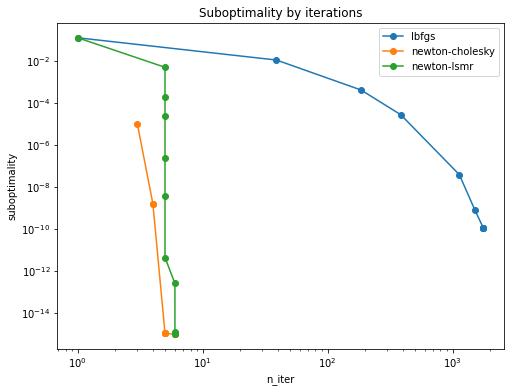

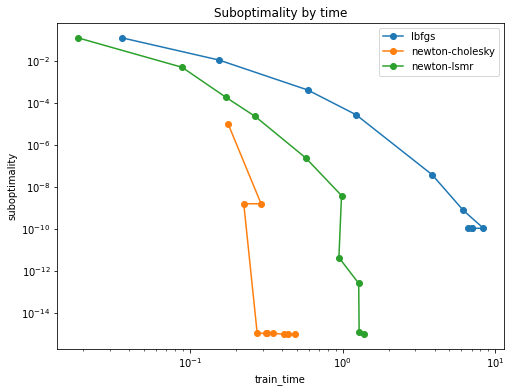

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
for label, group in results.groupby("solver"):
    group.sort_values("tol").plot(x="n_iter", y="suboptimality", loglog=True, marker="o", label=label, ax=ax)
ax.set_ylabel("suboptimality")
ax.set_title("Suboptimality by iterations")


fig, ax = plt.subplots(figsize=(8, 6))
for label, group in results.groupby("solver"):
    group.sort_values("tol").plot(x="train_time", y="suboptimality", loglog=True, marker="o", label=label, ax=ax)
ax.set_ylabel("suboptimality")
ax.set_title("Suboptimality by time")

### 3.2 Binary Regression on Kicks Dataset

In [25]:
import warnings
from pathlib import Path
import numpy as np
from sklearn._loss import HalfBinomialLoss
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.linear_model._glm.glm import _GeneralizedLinearRegressor
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from time import perf_counter
import pandas as pd
import joblib


class BinomialRegressor(_GeneralizedLinearRegressor):
    def _get_loss(self):
        return HalfBinomialLoss()


def prepare_data():
    df = fetch_openml(data_id=41162, as_frame=True, parser="auto").frame
    linear_model_preprocessor = ColumnTransformer(
        [
            (
                "passthrough_numeric",
                make_pipeline(SimpleImputer(), StandardScaler()),
                [
                    "MMRAcquisitionAuctionAveragePrice",
                    "MMRAcquisitionAuctionCleanPrice",
                    "MMRCurrentAuctionAveragePrice",
                    "MMRCurrentAuctionCleanPrice",
                    "MMRCurrentRetailAveragePrice",
                    "MMRCurrentRetailCleanPrice",
                    "MMRCurrentRetailAveragePrice",
                    "MMRCurrentRetailCleanPrice",
                    "VehBCost",
                    "VehOdo",
                    "VehYear",
                    "VehicleAge",
                    "WarrantyCost",
                ],
            ),
            (
                "onehot_categorical",
                OneHotEncoder(min_frequency=10),
                [
                    "Auction",
                    "Color",
                    "IsOnlineSale",
                    "Make",
                    "Model",
                    "Nationality",
                    "Size",
                    "SubModel",
                    "Transmission",
                    "Trim",
                    "WheelType",
                ],
            ),
        ],
        remainder="drop",
    )
    y = np.asarray(df["IsBadBuy"] == "1", dtype=float)
    X = linear_model_preprocessor.fit_transform(df)
    return X, y


X, y = prepare_data()
# X = X.toarray()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.9, random_state=0
)
print(f"{X_train.shape = }")

results = []
loss_sw = np.full_like(y_train, fill_value=(1. / y_train.shape[0]))
alpha = 1e-4
for tol in np.logspace(-1, -10, 10):
    for solver in ["lbfgs", "newton-cholesky", "newton-lsmr", "logreg-lbfgs", "logreg-newton-cg"]:
        tic = perf_counter()
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            if solver in ["lbfgs", "newton-cholesky", "newton-lsmr"]:
                reg = BinomialRegressor(
                    alpha=alpha, solver=solver, tol=tol, max_iter=10000
                ).fit(X_train, y_train)
            else:
                reg = LogisticRegression(
                    solver=solver[7:], C=1 / alpha / X.shape[0], tol=tol, max_iter=1000
                ).fit(X_train, y_train)
        toc = perf_counter()
        train_time = toc - tic
        train_loss = LinearModelLoss(
            base_loss=HalfBinomialLoss(), fit_intercept=reg.fit_intercept
        ).loss(
            coef=np.r_[np.squeeze(reg.coef_), reg.intercept_],
            X=X_train,
            y=y_train,
            l2_reg_strength=alpha,
            sample_weight=loss_sw,
        )
        result = {
            "solver": solver,
            "tol": tol,
            "train_loss": train_loss,
            "train_time": train_time,
            "train_score": reg.score(X_train, y_train),
            "test_score": reg.score(X_test, y_test),
            "n_iter": np.squeeze(reg.n_iter_),
            "converged": np.squeeze(reg.n_iter_) < np.squeeze(reg.max_iter),
        }
        print(result)
        results.append(result)


results = pd.DataFrame.from_records(results)
results.to_csv(Path().resolve() / "bench_logistic_reg.csv")

X_train.shape = (65684, 1076)
{'solver': 'lbfgs', 'tol': 0.1, 'train_loss': 0.3731549753225499, 'train_time': 0.008647369999835064, 'train_score': 5.551115123125783e-16, 'test_score': -3.324712741004099e-05, 'n_iter': array(0), 'converged': True}
{'solver': 'newton-cholesky', 'tol': 0.1, 'train_loss': 0.32596699957658853, 'train_time': 0.21463745100004417, 'train_score': 0.1345651615391461, 'test_score': 0.12152278565865304, 'n_iter': array(1), 'converged': True}
{'solver': 'newton-lsmr', 'tol': 0.1, 'train_loss': 0.36190532538448034, 'train_time': 0.02306941300003018, 'train_score': 0.030150200209420164, 'test_score': 0.03636429739383662, 'n_iter': array(1), 'converged': True}
{'solver': 'logreg-lbfgs', 'tol': 0.1, 'train_loss': 0.3066394204769179, 'train_time': 1.3952031039998474, 'train_score': 0.8950886060532245, 'test_score': 0.8968351829017673, 'n_iter': array(277, dtype=int32), 'converged': True}
{'solver': 'logreg-newton-cg', 'tol': 0.1, 'train_loss': 0.30663924180148766, 'trai

/Users/lorentzen/github/python3_sklearn/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/lorentzen/github/scikit-learn/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


{'solver': 'logreg-newton-cg', 'tol': 1e-06, 'train_loss': 0.30663920011190815, 'train_time': 2.711292326000148, 'train_score': 0.8950886060532245, 'test_score': 0.8968351829017673, 'n_iter': array(23, dtype=int32), 'converged': True}
{'solver': 'lbfgs', 'tol': 1e-07, 'train_loss': 0.3066283091209424, 'train_time': 1.8602479090000088, 'train_score': 0.1847543184845828, 'test_score': 0.17817214569792028, 'n_iter': array(379), 'converged': True}
{'solver': 'newton-cholesky', 'tol': 1e-07, 'train_loss': 0.3066283090943189, 'train_time': 0.9814540040001702, 'train_score': 0.18475422498142346, 'test_score': 0.17817238491616338, 'n_iter': array(5), 'converged': True}
{'solver': 'newton-lsmr', 'tol': 1e-07, 'train_loss': 0.3066283091316288, 'train_time': 1.9060553269998763, 'train_score': 0.18475414458585393, 'test_score': 0.17817231737885664, 'n_iter': array(5), 'converged': True}
{'solver': 'logreg-lbfgs', 'tol': 1e-07, 'train_loss': 0.3066394204769179, 'train_time': 1.5062998139999308, 'tr

/Users/lorentzen/github/python3_sklearn/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/lorentzen/github/scikit-learn/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


{'solver': 'logreg-newton-cg', 'tol': 1e-07, 'train_loss': 0.30663920011190815, 'train_time': 2.4534362469998996, 'train_score': 0.8950886060532245, 'test_score': 0.8968351829017673, 'n_iter': array(23, dtype=int32), 'converged': True}
{'solver': 'lbfgs', 'tol': 1e-08, 'train_loss': 0.30662830909492095, 'train_time': 2.0761112949999188, 'train_score': 0.1847542223510783, 'test_score': 0.17817237520782225, 'n_iter': array(438), 'converged': True}
{'solver': 'newton-cholesky', 'tol': 1e-08, 'train_loss': 0.3066283090943189, 'train_time': 0.958002426000121, 'train_score': 0.18475422498142346, 'test_score': 0.17817238491616338, 'n_iter': array(5), 'converged': True}
{'solver': 'newton-lsmr', 'tol': 1e-08, 'train_loss': 0.3066283090944652, 'train_time': 2.263845581999931, 'train_score': 0.18475421987136587, 'test_score': 0.1781723846465646, 'n_iter': array(5), 'converged': True}
{'solver': 'logreg-lbfgs', 'tol': 1e-08, 'train_loss': 0.3066394204769179, 'train_time': 1.6411258729999645, 'tra

/Users/lorentzen/github/python3_sklearn/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/lorentzen/github/scikit-learn/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


{'solver': 'logreg-newton-cg', 'tol': 1e-08, 'train_loss': 0.30663920011190815, 'train_time': 2.5800262509999357, 'train_score': 0.8950886060532245, 'test_score': 0.8968351829017673, 'n_iter': array(23, dtype=int32), 'converged': True}
{'solver': 'lbfgs', 'tol': 1e-09, 'train_loss': 0.30662830909492095, 'train_time': 2.0776581079999232, 'train_score': 0.1847542223510783, 'test_score': 0.17817237520782225, 'n_iter': array(438), 'converged': True}
{'solver': 'newton-cholesky', 'tol': 1e-09, 'train_loss': 0.3066283090943178, 'train_time': 1.1499666679999336, 'train_score': 0.18475422574286104, 'test_score': 0.17817238524771095, 'n_iter': array(6), 'converged': True}
{'solver': 'newton-lsmr', 'tol': 1e-09, 'train_loss': 0.30662830909431976, 'train_time': 2.82120666600008, 'train_score': 0.18475422584978451, 'test_score': 0.17817238507326338, 'n_iter': array(6), 'converged': True}
{'solver': 'logreg-lbfgs', 'tol': 1e-09, 'train_loss': 0.3066394204769179, 'train_time': 1.5286004110000704, 't

/Users/lorentzen/github/python3_sklearn/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/lorentzen/github/scikit-learn/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


{'solver': 'logreg-newton-cg', 'tol': 1e-09, 'train_loss': 0.30663920011190815, 'train_time': 2.543200522999996, 'train_score': 0.8950886060532245, 'test_score': 0.8968351829017673, 'n_iter': array(23, dtype=int32), 'converged': True}
{'solver': 'lbfgs', 'tol': 1e-10, 'train_loss': 0.30662830909492095, 'train_time': 2.1070988409999245, 'train_score': 0.1847542223510783, 'test_score': 0.17817237520782225, 'n_iter': array(438), 'converged': True}
{'solver': 'newton-cholesky', 'tol': 1e-10, 'train_loss': 0.3066283090943178, 'train_time': 1.2119234069998583, 'train_score': 0.18475422574286104, 'test_score': 0.17817238524771095, 'n_iter': array(6), 'converged': True}
{'solver': 'newton-lsmr', 'tol': 1e-10, 'train_loss': 0.30662830909431776, 'train_time': 3.3080421439999554, 'train_score': 0.18475422569457234, 'test_score': 0.17817238523821222, 'n_iter': array(6), 'converged': True}
{'solver': 'logreg-lbfgs', 'tol': 1e-10, 'train_loss': 0.3066394204769179, 'train_time': 1.4697552770001039, '

/Users/lorentzen/github/python3_sklearn/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/lorentzen/github/scikit-learn/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [26]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


results = pd.read_csv(Path().resolve() / "bench_logistic_reg.csv")
results["suboptimality"] = results["train_loss"] - results["train_loss"].min() + 1e-15

In [27]:
results

,Unnamed: 0,solver,tol,train_loss,train_time,train_score,test_score,n_iter,converged,suboptimality
0,0,lbfgs,1.000000e-01,0.373155,0.008647,5.551115e-16,-0.000033,0,True,6.652667e-02
1,1,newton-cholesky,1.000000e-01,0.325967,0.214637,1.345652e-01,0.121523,1,True,1.933869e-02
2,2,newton-lsmr,1.000000e-01,0.361905,0.023069,3.015020e-02,0.036364,1,True,5.527702e-02
3,3,logreg-lbfgs,1.000000e-01,0.306639,1.395203,8.950886e-01,0.896835,277,True,1.111138e-05
4,4,logreg-newton-cg,1.000000e-01,0.306639,0.833232,8.950886e-01,0.896835,14,True,1.093271e-05
5,5,lbfgs,1.000000e-02,0.315144,0.052685,1.562929e-01,0.165333,8,True,8.515253e-03
6,6,newton-cholesky,1.000000e-02,0.306655,0.580697,1.845186e-01,0.177997,3,True,2.624481e-05
7,7,newton-lsmr,1.000000e-02,0.312979,0.078014,1.626419e-01,0.167770,2,True,6.350277e-03
8,8,logreg-lbfgs,1.000000e-02,0.306639,1.565462,8.950886e-01,0.896835,277,True,1.111138e-05
9,9,logreg-newton-cg,1.000000e-02,0.306639,1.401446,8.950886e-01,0.896835,19,True,1.088958e-05


Text(0.5, 1.0, 'Suboptimality by time, sparse X')

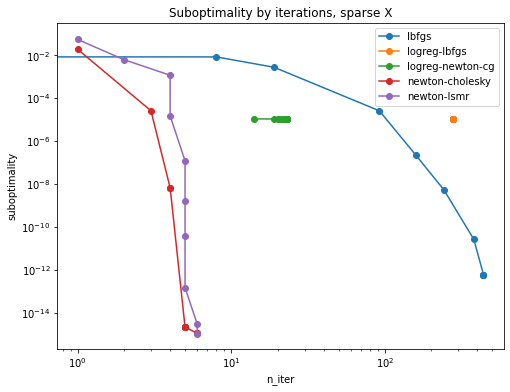

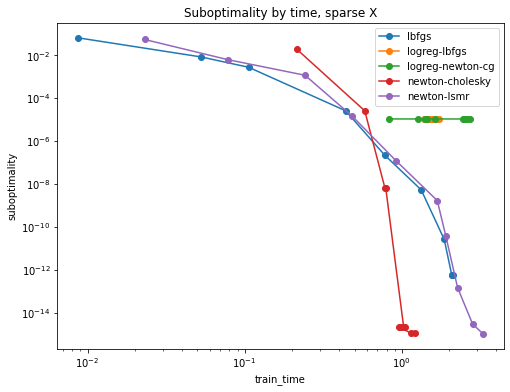

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
for label, group in results.groupby("solver"):
    group.sort_values("tol").plot(x="n_iter", y="suboptimality", loglog=True, marker="o", label=label, ax=ax)
ax.set_ylabel("suboptimality")
ax.set_title("Suboptimality by iterations, sparse X")


fig, ax = plt.subplots(figsize=(8, 6))
for label, group in results.groupby("solver"):
    group.sort_values("tol").plot(x="train_time", y="suboptimality", loglog=True, marker="o", label=label, ax=ax)
ax.set_ylabel("suboptimality")
ax.set_title("Suboptimality by time, sparse X")

## 4. Some Experiments

In [1]:
from functools import partial
import numpy as np
from scipy import linalg
from scipy.optimize import minimize, root

from sklearn._loss import HalfBinomialLoss
from sklearn.base import clone
from sklearn.datasets import make_low_rank_matrix
from sklearn.linear_model._glm import _GeneralizedLinearRegressor
from sklearn.linear_model._linear_loss import LinearModelLoss
from sklearn.linear_model import (
    GammaRegressor,
    PoissonRegressor,
    Ridge,
    TweedieRegressor,
)


class BinomialRegressor(_GeneralizedLinearRegressor):
    def _get_loss(self):
        return HalfBinomialLoss()

def _special_minimize(fun, grad, x, tol_NM, tol):
    # Find good starting point by Nelder-Mead
    res_NM = minimize(
        fun, x, method="Nelder-Mead", options={"xatol": tol_NM, "fatol": tol_NM}
    )
    # Now refine via root finding on the gradient of the function, which is
    # more precise than minimizing the function itself.
    res = root(
        grad,
        res_NM.x,
        method="lm",
        options={"ftol": tol, "xtol": tol, "gtol": tol},
    )
    return res.x

def glm_dataset(global_random_seed, data_type, model):
    # Make larger dim more than double as big as the smaller one.
    # This helps when constructing singular matrices like (X, X).
    if data_type == "long":
        n_samples, n_features = 12, 4
    else:
        n_samples, n_features = 4, 12
    k = min(n_samples, n_features)
    rng = np.random.RandomState(global_random_seed)
    X = make_low_rank_matrix(
        n_samples=n_samples,
        n_features=n_features,
        effective_rank=k,
        tail_strength=0.1,
        random_state=rng,
    )
    X[:, -1] = 1  # last columns acts as intercept
    U, s, Vt = linalg.svd(X, full_matrices=False)
    assert np.all(s > 1e-3)  # to be sure
    assert np.max(s) / np.min(s) < 100  # condition number of X

    if data_type == "long":
        coef_unpenalized = rng.uniform(low=1, high=3, size=n_features)
        coef_unpenalized *= rng.choice([-1, 1], size=n_features)
        raw_prediction = X @ coef_unpenalized
    else:
        raw_prediction = rng.uniform(low=-3, high=3, size=n_samples)
        # minimum norm solution min ||w||_2 such that raw_prediction = X w:
        # w = X'(XX')^-1 raw_prediction = V s^-1 U' raw_prediction
        coef_unpenalized = Vt.T @ np.diag(1 / s) @ U.T @ raw_prediction

    linear_loss = LinearModelLoss(base_loss=model._get_loss(), fit_intercept=True)
    sw = np.full(shape=n_samples, fill_value=1 / n_samples)
    y = linear_loss.base_loss.link.inverse(raw_prediction)

    # Add penalty l2_reg_strength * ||coef||_2^2 for l2_reg_strength=1 and solve with
    # optimizer. Note that the problem is well conditioned such that we get accurate
    # results.
    l2_reg_strength = 1
    fun = partial(
        linear_loss.loss,
        X=X[:, :-1],
        y=y,
        sample_weight=sw,
        l2_reg_strength=l2_reg_strength,
    )
    grad = partial(
        linear_loss.gradient,
        X=X[:, :-1],
        y=y,
        sample_weight=sw,
        l2_reg_strength=l2_reg_strength,
    )
    coef_penalized_with_intercept = _special_minimize(
        fun, grad, coef_unpenalized, tol_NM=1e-6, tol=1e-14
    )

    linear_loss = LinearModelLoss(base_loss=model._get_loss(), fit_intercept=False)
    fun = partial(
        linear_loss.loss,
        X=X[:, :-1],
        y=y,
        sample_weight=sw,
        l2_reg_strength=l2_reg_strength,
    )
    grad = partial(
        linear_loss.gradient,
        X=X[:, :-1],
        y=y,
        sample_weight=sw,
        l2_reg_strength=l2_reg_strength,
    )
    coef_penalized_without_intercept = _special_minimize(
        fun, grad, coef_unpenalized[:-1], tol_NM=1e-6, tol=1e-14
    )

    # To be sure
    assert np.linalg.norm(coef_penalized_with_intercept) < np.linalg.norm(
        coef_unpenalized
    )

    return (
        model,
        X,
        y,
        coef_unpenalized,
        coef_penalized_with_intercept,
        coef_penalized_without_intercept,
        l2_reg_strength,
    )

In [2]:
# BinomialRegressor(),
# PoissonRegressor(),
# GammaRegressor(),
# TweedieRegressor(power=3.0),
# TweedieRegressor(power=0, link="log"),
# TweedieRegressor(power=1.5),
model, X, y, coef, _, _, l2_reg_strength = glm_dataset(42, "wide", PoissonRegressor())

In [3]:
coef

array([-0.81238776,  0.28118357,  0.0573311 ,  0.23317832, -1.1689431 ,
       -0.62519939,  0.4729572 , -0.86492852, -0.93802063,  0.05346216,
       -0.40870182,  1.28375014])

In [4]:
n_samples, n_features = X.shape
fit_intercept = True
alpha = 0  # unpenalized
params = dict(
    alpha=alpha,
    fit_intercept=fit_intercept,
    solver="newton-cholesky",
    tol=1e-12,
    max_iter=20, #1000
    verbose=2
)

model = clone(model).set_params(**params)
# Note that newton-cholesky might give a warning: XXX
if fit_intercept:
    X = X[:, :-1]  # remove intercept
    intercept = coef[-1]
    coef = coef[:-1]
else:
    intercept = 0
model.fit(X, y)

Newton iter=1
  The inner solver stumbled upon an singular or ill-conditioned Hessian matrix and resorts to LBFGS instead.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00994D+00    |proj g|=  7.62101D-01

At iterate    1    f= -3.09252D+00    |proj g|=  3.63067D-01

At iterate    2    f= -3.33056D+00    |proj g|=  4.69880D-01

At iterate    3    f= -3.37719D+00    |proj g|=  1.33463D-01

At iterate    4    f= -3.38799D+00    |proj g|=  7.08606D-02

At iterate    5    f= -3.39855D+00    |proj g|=  3.00971D-02

At iterate    6    f= -3.40189D+00    |proj g|=  1.93301D-02

At iterate    7    f= -3.40517D+00    |proj g|=  9.10050D-03

At iterate    8    f= -3.40518D+00    |proj g|=  5.10392D-04

At iterate    9    f= -3.40518D+00    |proj g|=  7.59308D-05

At iterate   10    f= -3.40518D+00    |proj g|=  1.12169D-05

At iterate   11    f= -3.40

/Users/lorentzen/github/scikit-learn/sklearn/linear_model/_glm/glm.py:548: LinAlgWarning: The inner solver of CholeskyNewtonSolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinearfeatures of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.66793e-19): result may not be accurate.
  warnings.warn(
 This problem is unconstrained.


PoissonRegressor(alpha=0, max_iter=20, solver='newton-cholesky', tol=1e-12,
                 verbose=2)

In [5]:
model.intercept_, intercept

(1.4033475207675112, 1.2837501395684474)

In [6]:
model.coef_, coef

(array([-0.51271544,  0.34077274,  0.10015787,  0.05429584, -1.10015221,
        -0.70850177,  0.47091363, -0.90868854, -1.01392268, -0.02517041,
        -0.49892198]),
 array([-0.81238776,  0.28118357,  0.0573311 ,  0.23317832, -1.1689431 ,
        -0.62519939,  0.4729572 , -0.86492852, -0.93802063,  0.05346216,
        -0.40870182]))

In [7]:
np.c_[np.arange(4).reshape(2, 2), [1, 1]]

array([[0, 1, 1],
       [2, 3, 1]])

### IRLS SVD Solver
This is from an unpublished branch.

In [10]:
from sklearn.linear_model._glm.glm import IRLS_SVD_NewtonSolver

fit_intercept = False
solver = IRLS_SVD_NewtonSolver

model, X, y, _, coef_with_intercept, coef_without_intercept, alpha = glm_dataset(42, "wide", PoissonRegressor())

params = dict(
    alpha=alpha,
    fit_intercept=fit_intercept,
    solver=solver,
    tol=1e-13,
    max_iter=5,
    verbose=3,
)

model = clone(model).set_params(**params)
X = X[:, :-1]  # remove intercept
if fit_intercept:
    coef = coef_with_intercept
    intercept = coef[-1]
    coef = coef[:-1]
else:
    coef = coef_without_intercept
    intercept = 0

model.fit(X, y)

linear_loss = LinearModelLoss(
        base_loss=model._get_loss(),
        fit_intercept=fit_intercept,
    )
objective_ref = linear_loss.loss(
    coef=np.r_[coef, intercept] if fit_intercept else coef,
    X=X,
    y=y,
    sample_weight=np.ones_like(y) / y.shape[0],
    l2_reg_strength=alpha,
)
objective_glm = linear_loss.loss(
    coef=np.r_[model.coef_, model.intercept_] if fit_intercept else model.coef_,
    X=X,
    y=y,
    sample_weight=np.ones_like(y) / y.shape[0],
    l2_reg_strength=alpha,
)

objective_ref, objective_glm, (objective_glm - objective_ref) / np.abs(objective_ref)

Newton iter=1
coef=[-0.96642856  0.25563581 -0.00675664  0.43569906 -0.61185289  0.29368562
  0.31557291 -0.38373063 -0.05825936 -0.1342783  -0.14886083]
coef_newton=[-0.96642856  0.25563581 -0.00675664  0.43569906 -0.61185289  0.29368562
  0.31557291 -0.38373063 -0.05825936 -0.1342783  -0.14886083]
gradient=[ 1.07133883 -0.34357639  0.01378704 -0.44826904  0.67656298 -0.34006801
 -0.37757788  0.47918503  0.05870614  0.19186281  0.20741317]
coef_newton @ gradient=-2.195526727941255
loss=-0.04487186581186209
  Check Convergence
    1. max |gradient| 0.07139354630155725 <= 1e-13
Newton iter=2
coef=[-0.91461097  0.22534333 -0.00963467  0.41669098 -0.57515722  0.26444111
  0.2900338  -0.35084886 -0.05756114 -0.11001262 -0.12832072]
coef_newton=[ 0.05181759 -0.03029247 -0.00287803 -0.01900809  0.03669567 -0.02924451
 -0.02553911  0.03288177  0.00069822  0.02426568  0.02054012]
gradient=[-7.13935463e-02  4.67919044e-02  3.00336918e-03  2.29208401e-02
 -4.96727731e-02  4.13064900e-02  3.73336

(-0.051275186581750454, -0.05127518658175034, 2.165224738587885e-15)

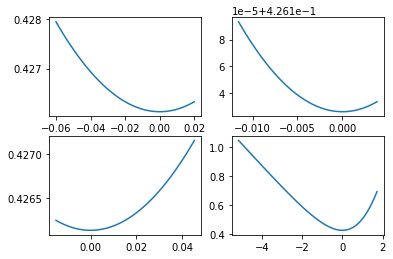

In [3]:
# Vizualize loss after first iteration
import matplotlib.pyplot as plt

def local_loss(x, i):
    coef = np.array([-0.02003306, -0.00384949, 0.01506864, -1.71676688])
    loss = []
    for j in range(len(x)):
        c = coef.copy()
        c[i] += x[j]
        loss.append(
            linear_loss.loss(
                coef=c,
                X=X,
                y=y,
                sample_weight=np.ones_like(y) / y.shape[0],
                l2_reg_strength=alpha,
            )
        )
    return np.array(loss)

fig, axes = plt.subplots(2, 2)
coef = np.array([-0.02003306, -0.00384949, 0.01506864, -1.71676688])

for i in range(4):
    ax = axes.ravel()[i] 
    x = coef[i] + 2 * np.linspace(-np.abs(coef[i]), np.abs(coef[i]), 100)
    ax.plot(x, local_loss(x, i))